# Problem Statement

Obtain the actitivities of daily life dataset from the UC Irvine machine learning website (https://archive.ics.uci.edu/ml/datasets/Dataset+for+ADL+Recognition+with+Wrist-worn+Accelerometer, data provided by Barbara Bruno, Fulvio Mastrogiovanni and Antonio Sgorbissa). Ignore the directories with MODEL in the name. They are duplicates.

(a) Build a classifier that classifies sequences into one of the 14 activities provided and evaluate its performance using average accuracy over 3 fold cross validation. To do the cross validation, divide the data for each class into 3 folds separately. Then, for a given run you will select 2 folds from each class for training and use the remaining fold from each class for test. To make features, you should vector quantize, then use a histogram of cluster center. This method is described in great detail in the book in section 9.3 which begins on page 166. You will find it helpful to use hierarchical k-means to vector quantize. You may perform the vector quantization for the entire dataset before doing cross validation.

You may use whatever multi-class classifier you wish, though we'd suggest you use a decision forest because it's easy to use and effective.

You should report (i) the average error rate over 3 fold cross validation and (ii) the class confusion matrix of your classifier for the fold with the lowest error, i.e. just one matrix for the 3 folds.

(b) Now see if you can improve your classifier by (i) modifying the number of cluster centers in your hierarchical k-means and (ii) modifying the size of the fixed length samples that you see.

In [0]:
import zipfile
zip_ref = zipfile.ZipFile('HMP_Dataset.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict
from os import path
from scipy.cluster.vq import vq
import os
import random

In [0]:
def fetch_segmented_data(file_data, time_unit):
    rows = np.shape(file_data)[0]
    mod_value = rows % time_unit
    if mod_value != 0:
        new_data = np.array(file_data)[:-mod_value, :]
    else:
        new_data = np.array(file_data)
    segmented_data = new_data.reshape(int(rows / time_unit), time_unit * 3)
    return pd.DataFrame(segmented_data)

def fetch_data(path_index, clusters, time_unit):
    files_per_activity = os.listdir(path_index)
    train_len = int(0.67 * len(files_per_activity))  
    train_data_all = pd.DataFrame()
    test_data_all = pd.DataFrame()
    #generating segmented train data
    for file in files_per_activity[:train_len]:
        file_path = os.path.join(path_index, file)  
        file_data = pd.read_csv(file_path, sep=" ", index_col=None, names=['x', 'y', 'z'], skip_blank_lines=True).dropna()
        segmented_train_data = fetch_segmented_data(file_data, time_unit)
        train_data_all = train_data_all.append(segmented_train_data, ignore_index=True)
    
    #generating segmented test data    
    for file in files_per_activity[train_len:]:
        file_path = os.path.join(path_index, file) 
        file_data = pd.read_csv(file_path, sep=" ", index_col=None, names=['x', 'y', 'z'], skip_blank_lines=True).dropna()
        segmented_test_data = fetch_segmented_data(file_data, time_unit)
        test_data_all = test_data_all.append(segmented_train_data, ignore_index=True)
      
        
    return train_data_all, test_data_all
    
def create_feature_vectors(clusters, time_unit, path_index_list):
    df1_train, df1_test = fetch_data(path_index_list[0], clusters, time_unit)
    df2_train, df2_test = fetch_data(path_index_list[1], clusters, time_unit)
    df3_train, df3_test = fetch_data(path_index_list[2], clusters, time_unit)
    df4_train, df4_test = fetch_data(path_index_list[3], clusters, time_unit)
    df5_train, df5_test = fetch_data(path_index_list[4], clusters, time_unit)
    df6_train, df6_test = fetch_data(path_index_list[5], clusters, time_unit)
    df7_train, df7_test = fetch_data(path_index_list[6], clusters, time_unit)
    df8_train, df8_test = fetch_data(path_index_list[7], clusters, time_unit)
    df9_train, df9_test = fetch_data(path_index_list[8], clusters, time_unit)
    df10_train, df10_test = fetch_data(path_index_list[9], clusters, time_unit)
    df11_train, df11_test = fetch_data(path_index_list[10], clusters, time_unit)
    df12_train, df12_test = fetch_data(path_index_list[11], clusters, time_unit)
    df13_train, df13_test = fetch_data(path_index_list[12], clusters, time_unit)
    df14_train, df14_test = fetch_data(path_index_list[13], clusters, time_unit)
    train_data_all_activity = np.concatenate([df1_train, df2_train, df3_train, df4_train, df5_train, df6_train, df7_train, df8_train, df9_train, df10_train, df11_train, df12_train, df13_train, df14_train])
    return train_data_all_activity

def fetch_features_for_classifier(k_means, index, cluster_n, time_unit, path_index_list):
    files_per_activity = os.listdir(index)
    train_length = int(0.67 * len(files_per_activity))
    train_features = pd.DataFrame()  
    test_features = pd.DataFrame()
    for file in files_per_activity[:train_length]: 
        file_path = os.path.join(index, file)  
        file_data = pd.read_csv(file_path, sep=" ", index_col=None, names=['x', 'y', 'z'], skip_blank_lines=True).dropna()
        segmented_train_data= fetch_segmented_data(file_data,  time_unit)  
        assignments = vq(segmented_train_data, k_means.cluster_centers_)
        assignments_array = np.array(assignments[0])  
        features = [0 for s in range(0, cluster_n + 1)] 
        for i in assignments_array:
            features[i] += 1
        features[cluster_n] = path_index_list.index(index) + 1 
        df_features = pd.DataFrame(np.array(features).reshape(1, cluster_n + 1)) 
        train_features = train_features.append(df_features)
        
    for file in files_per_activity[train_length:]: 
        file_path = os.path.join(index, file)  
        file_data = pd.read_csv(file_path, sep=" ", index_col=None, names=['x', 'y', 'z'], skip_blank_lines=True).dropna()
        segmented_test_data= fetch_segmented_data(file_data, time_unit)  
        assignments = vq(segmented_test_data, k_means.cluster_centers_)
        assignments_array = np.array(assignments[0])  
        features = [0 for s in range(0, cluster_n + 1)] 
        for i in assignments_array:
            features[i] += 1
        features[cluster_n] = path_index_list.index(index) + 1 
        df_features = pd.DataFrame(np.array(features).reshape(1, cluster_n + 1)) 
        test_features = test_features.append(df_features)
        
    return train_features, test_features

def fetch_classifier_features(train_feature_vectors, cluster_n, path_index_list, time_unit):
    k_means = KMeans(n_clusters=cluster_n, random_state=0).fit(train_feature_vectors)
    training_classifier = pd.DataFrame()
    test_classifier = pd.DataFrame()
    for index in path_index_list:
        train, test = fetch_features_for_classifier(k_means, index, cluster_n, time_unit, path_index_list)
        training_classifier = training_classifier.append(train)
        test_classifier = test_classifier.append(test)
    return training_classifier, test_classifier
  
#Program starts here

DATA_PATH = "HMP_Dataset"
clusters = 480 
time_unit = 32
path_index_list = [os.path.join(DATA_PATH, 'Brush_teeth'), os.path.join(DATA_PATH, 'Climb_stairs'),
                   os.path.join(DATA_PATH, 'Comb_hair'), os.path.join(DATA_PATH, 'Descend_stairs'), 
                   os.path.join(DATA_PATH, 'Drink_glass'),
                   os.path.join(DATA_PATH, 'Eat_meat'),
                   os.path.join(DATA_PATH, 'Eat_soup'), os.path.join(DATA_PATH, 'Getup_bed'),
                   os.path.join(DATA_PATH, 'Liedown_bed'), os.path.join(DATA_PATH, 'Pour_water'),
                   os.path.join(DATA_PATH, 'Sitdown_chair'), os.path.join(DATA_PATH, 'Standup_chair'),
                   os.path.join(DATA_PATH, 'Use_telephone'),
                   os.path.join(DATA_PATH, 'Walk')]
segment_length = 32  # set the segment length
cluster_n = 480 #set the cluster size
train_feature_vectors = create_feature_vectors(cluster_n, time_unit, path_index_list) #create segmented records for training
training_classifier, test_classifier = fetch_classifier_features(train_feature_vectors, cluster_n, path_index_list, time_unit) 

In [4]:
#3-Fold cross validation with Random Forest classifier
total_data = pd.DataFrame(np.concatenate([training_classifier,test_classifier]))
X = total_data.iloc[: , :cluster_n]
y = total_data.iloc[: , cluster_n]
rf = RFC(max_depth=48, n_estimators=100, random_state=8)
rf.fit(X, y)
accuracy= cross_val_score(rf, X, y, cv=3, scoring='accuracy')
print(f'Mean accuracy across 3-Folds: {accuracy.mean()}')
y_pred = cross_val_predict(rf, X, y, cv=3)
# Making the Confusion Matrix
cm = confusion_matrix(y, y_pred)
print(f'Confusion Matrix: \n {cm}')

Mean accuracy across 3-Folds: 0.7273562385789308
Confusion Matrix: 
 [[ 9  0  0  0  0  0  0  0  0  1  0  2  0  0]
 [ 0 91  0  0  3  0  0  1  0  1  1  2  0  3]
 [ 0  0 16  0 12  0  0  0  0  1  1  1  0  0]
 [ 0 11  0 28  0  0  0  0  0  0  2  1  0  0]
 [ 0  0  0  0 98  0  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  1  2  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  3  0  0  0  0]
 [ 0  0  0  0  7  0  0 54  0  7  7 26  0  0]
 [ 0  1  0  0  1  0  0  8  1  4 13  0  0  0]
 [ 0  0  0  0  2  0  0  0  0 95  3  0  0  0]
 [ 0  0  0  0  0  0  0  5  0  1 78 16  0  0]
 [ 0  0  0  0  1  0  0  6  0  1 30 64  0  0]
 [ 0  0  0  0  6  0  0  0  0  2  1  1  3  0]
 [ 0 19  0  0  0  0  0  0  0  0  5  5  0 71]]


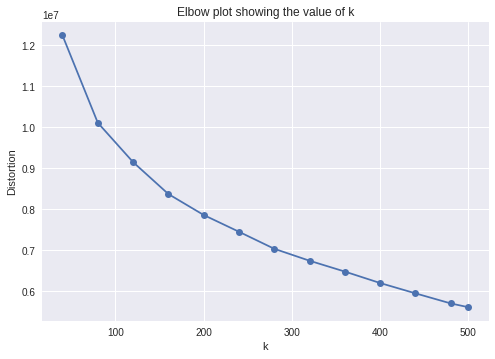

In [5]:
#Experimenting with different cluster size and segment length 

#Estimating the right cluster value
cluster_list = [40, 80, 120, 160, 200, 240, 280, 320, 360, 400, 440, 480, 500]
time_unit_list = [4,8, 12,16, 20, 24, 28, 32, 36, 40]
dist_list=[]

for k in cluster_list:
    k_means = KMeans(n_clusters=k, random_state=6).fit(train_feature_vectors)  # fit the data on different values of k
    dist_list.append(k_means.inertia_)
    
plt.plot(cluster_list, dist_list, marker="o")  # plot the inertia against k
plt.xlabel('k')  # label x axis
plt.ylabel('Distortion')  # label y axis
plt.title('Elbow plot showing the value of k')  # set the plot title
plt.grid(True)  # set grid on
plt.show()

In [0]:
# calculate the accuracy for different value of clusters
time_unit =32
accuracy_cluster_list = []
for cluster_n in cluster_list:
    train_feature_vectors = create_feature_vectors(cluster_n, time_unit, path_index_list)
    training_classifier, test_classifier = fetch_classifier_features(train_feature_vectors, cluster_n, path_index_list, time_unit)
    rf2 = RFC(max_depth=32, random_state=8, n_estimators=100)
    X=training_classifier.iloc[:, :cluster_n]
    y=training_classifier.iloc[:, cluster_n]
    rf2.fit(X, y)
    accuracy= cross_val_score(rf2, X, y, cv=3, scoring='accuracy')
    accuracy_cluster_list.append(accuracy.mean())


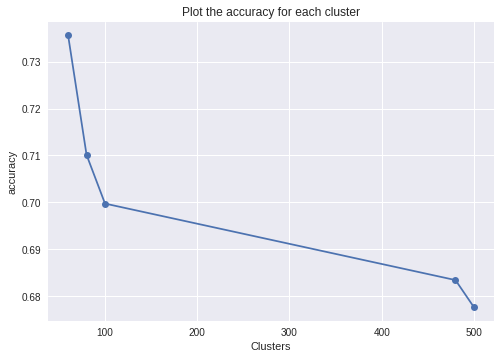

In [34]:
#print(list(zip(cluster_list,accuracy_cluster_list)))
plt.plot(cluster_list, accuracy_cluster_list, marker="o")  # Plot the accuracy for each cluster
plt.xlabel('Clusters')  # label x axis
plt.ylabel('accuracy')  # label y axis
plt.title('Plot the accuracy for each cluster')  # set the plot title
plt.grid(True)  # set grid on
plt.show()


In [0]:
# calculate the accuracy for different value of segment length
cluster_n = 60
accuracy_segment_list = []
for time_unit in time_unit_list:
    train_feature_vectors = create_feature_vectors(cluster_n, time_unit, path_index_list)
    training_classifier, test_classifier = fetch_classifier_features(train_feature_vectors, cluster_n, path_index_list, time_unit)
    rf3 = RFC(max_depth=32, random_state=8, n_estimators=90)
    X=training_classifier.iloc[:, :cluster_n]
    y=training_classifier.iloc[:, cluster_n]
    rf3.fit(X, y)    
    accuracy= cross_val_score(rf3, X, y, cv=3, scoring='accuracy')
    accuracy_segment_list.append(accuracy.mean())

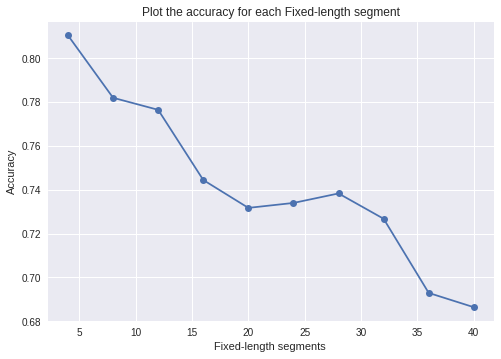

In [38]:
#print(list(zip(time_unit_list,accuracy_segment_list)))
plt.plot(time_unit_list, accuracy_segment_list, marker="o")  # Plot the accuracy for each cluster
plt.xlabel('Fixed-length segments ')  # label x axis
plt.ylabel('Accuracy')  # label y axis
plt.title('Plot the accuracy for each Fixed-length segment')  # set the plot title
plt.grid(True)  # set grid on
plt.show()

In [39]:
#3-Fold cross validation with Random Forest classifier to choose the best K-value and segment_length

cluster_list = [60, 80, 100, 480, 500]
time_unit_list = [4, 8, 16, 32]
accuracy_list = []
for cluster_n in cluster_list:
  for time_unit in time_unit_list:
    train_feature_vectors = create_feature_vectors(cluster_n, time_unit, path_index_list)
    training_classifier, test_classifier = fetch_classifier_features(train_feature_vectors, cluster_n, path_index_list, time_unit)
    total_data = pd.DataFrame(np.concatenate([training_classifier,test_classifier]))
    X = total_data.iloc[: , :cluster_n]
    y = total_data.iloc[: , cluster_n]
    rf = RFC(max_depth=48, n_estimators=100, random_state=8)
    rf.fit(X, y)
    accuracy= cross_val_score(rf, X, y, cv=3, scoring='accuracy')
    accuracy_list.append([accuracy.mean(), cluster_n, time_unit])
    
print(accuracy_list)

[[0.823668387944107, 60, 4], [0.7891834815900141, 60, 8], [0.7571261068948045, 60, 16], [0.7413305053897385, 60, 32], [0.7974468937435865, 80, 4], [0.7666078578784571, 80, 8], [0.7536260236661928, 80, 16], [0.7392722892624116, 80, 32], [0.7975907603436702, 100, 4], [0.7786832319041791, 100, 8], [0.7559497482105849, 100, 16], [0.7212152474816486, 100, 32], [0.7501365497990623, 480, 4], [0.7595381818115302, 480, 8], [0.7687129015323211, 480, 16], [0.7273562385789308, 480, 32], [0.7521083362143237, 500, 4], [0.7452708771198143, 500, 8], [0.7641281940122959, 500, 16], [0.7143729410064625, 500, 32]]


In [40]:
# #3-Fold cross validation with Random Forest classifier
#Best Guess cluster_n = 60 , time_unit = 4

cluster_n = 60
time_unit = 4
segment_length = time_unit
train_feature_vectors = create_feature_vectors(cluster_n, time_unit, path_index_list)
training_classifier, test_classifier = fetch_classifier_features(train_feature_vectors, cluster_n, path_index_list, time_unit)
total_data = pd.DataFrame(np.concatenate([training_classifier,test_classifier]))
X = total_data.iloc[: , :cluster_n]
y = total_data.iloc[: , cluster_n]
rf = RFC(max_depth=48, n_estimators=100, random_state=8)
rf.fit(X, y)
accuracy= cross_val_score(rf, X, y, cv=3, scoring='accuracy')
print(accuracy.mean())
y_pred = cross_val_predict(rf, X, y, cv=3)
# Making the Confusion Matrix
cm = confusion_matrix(y, y_pred)
print(f'Confusion Matrix: \n {cm}')

0.823668387944107
Confusion Matrix: 
 [[ 11   0   0   0   0   0   0   0   0   0   1   0   0   0]
 [  0  94   0   1   1   0   0   1   0   0   1   0   0   4]
 [  0   0  31   0   0   0   0   0   0   0   0   0   0   0]
 [  0   6   0  36   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  99   0   0   0   0   1   0   0   0   0]
 [  0   0   0   0   0   5   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   2   0   0   1   0   0   0   0]
 [  0   2   0   0   0   0   0  84   1   1   5   8   0   0]
 [  0   0   0   0   0   0   0  16   1   1   8   2   0   0]
 [  0   0   0   0   0   0   0   0   0 100   0   0   0   0]
 [  0   0   0   0   0   0   0   2   0   1  73  24   0   0]
 [  0   0   0   0   0   0   0   3   0   1  22  76   0   0]
 [  0   0   1   0   4   0   0   0   0   6   1   0   1   0]
 [  0  16   0   1   0   0   0   0   0   0   3   2   0  78]]


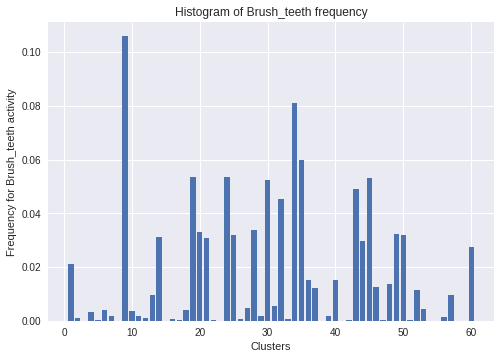

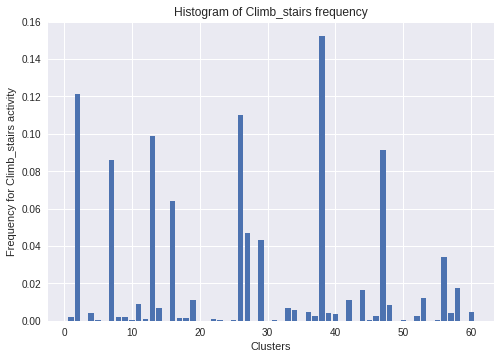

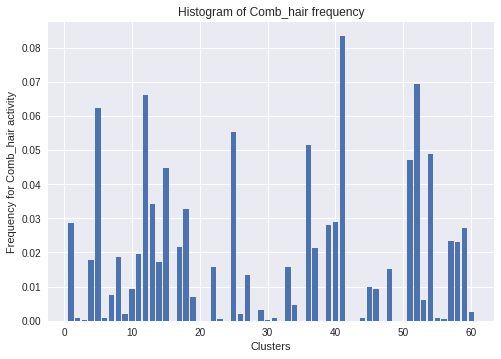

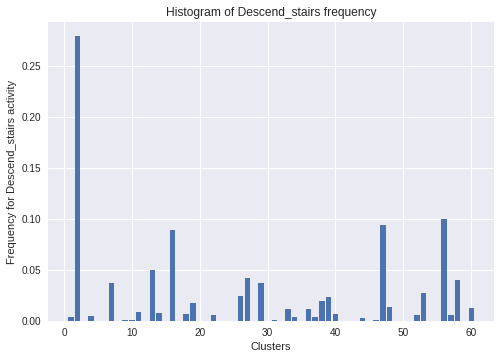

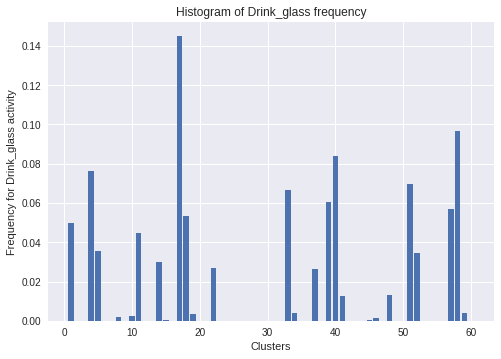

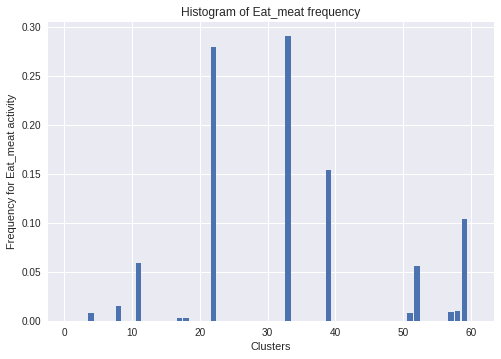

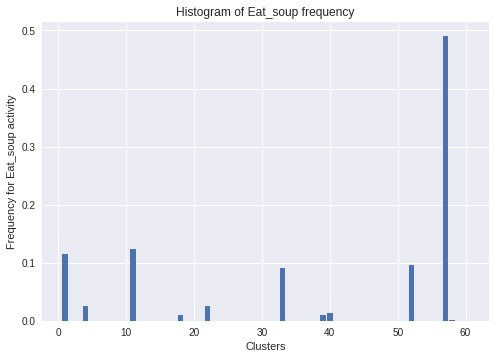

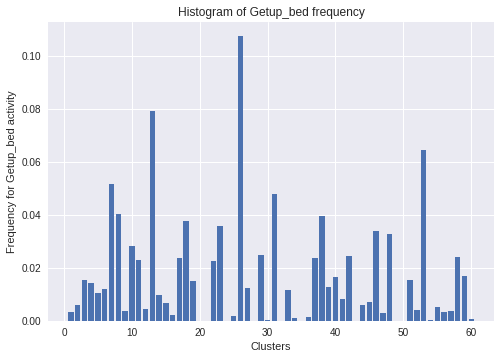

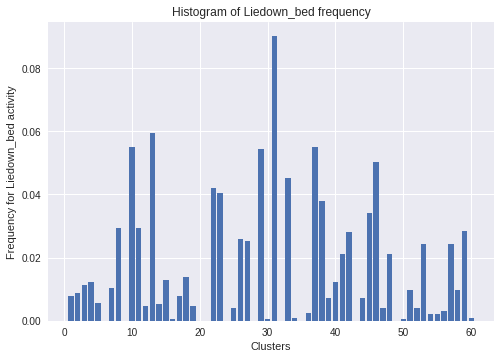

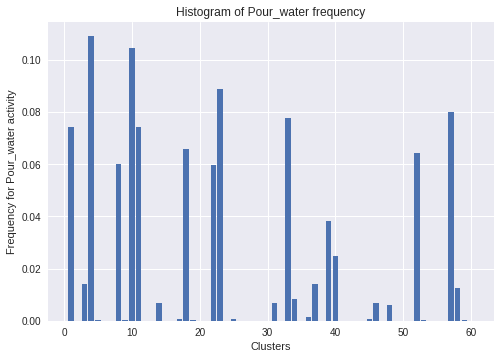

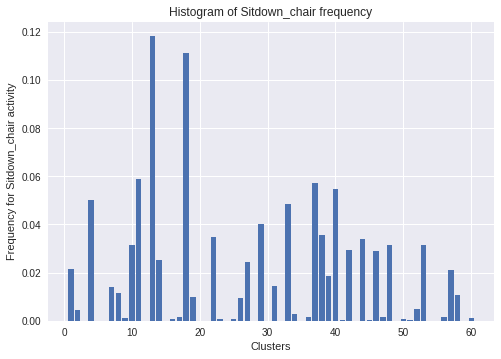

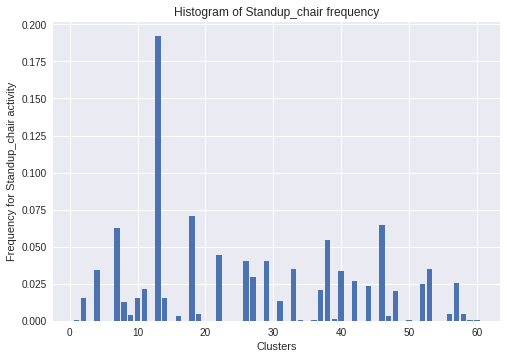

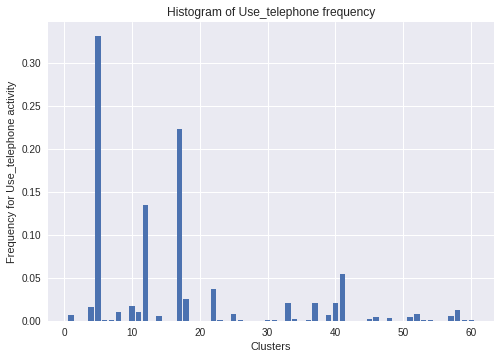

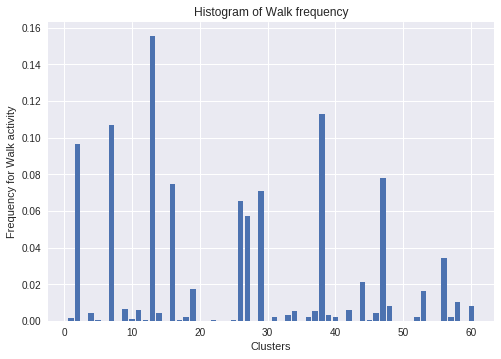

In [43]:
#Histogram
df = training_classifier.groupby(60).sum()
for i in range(1,15):
  value = int(list(df.sum(axis=1)[df.sum(axis=1).index==i])[0])
  y_axis = list(np.array(df[df.index==i]/value))[0]
  x_axis = list([x for x in range(1,61)])
  plt.xlabel('Clusters')
  plt.ylabel(f'Frequency for {path_index_list[i-1][12:]} activity')
  plt.title(f'Histogram of {path_index_list[i-1][12:]} frequency')
  plt.bar(x_axis, y_axis)
  #plt.savefig(path_index_list[i-1][12:]+'.png')
  plt.show()
  #plt.close()